### NLP Assignment
#### Ali Soltan Mohammadi
#### ali.s.mohammadi@znu.ac.ir

##### In the first part, you plan to use pre-trained vectors like 'glove.6B.50d.txt' for the first layer of the neural network. For the second part, we intend to train the vectors within the network using one-hot encoding for input data. This approach involves leveraging pre-trained word embeddings for the initial layer and then training the network further with one-hot encoding for input data in the subsequent layers.

# Necesary Library

In [2]:
import os
import nltk
import csv
import string
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from numpy import array
from keras.preprocessing.text import one_hot
from nltk.corpus import stopwords
from keras.regularizers import l2
from tensorflow.python.keras import regularizers
from collections import defaultdict
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, Input, Embedding, Lambda, LSTM, Reshape, Dropout, Flatten
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss

#  First Part

# Step1: Reading Data

In [3]:
# read the contents of the file
with open('dataset/train.txt', 'r') as f:
    data = f.read()
    
with open('dataset/test.txt', 'r') as f:
    test_data = f.read()
data1 = test_data

In [4]:
def clean_txt(corpus):
    tokens = corpus.split()
    tokens = [t for t in tokens if t not in string.punctuation]
    tokens = [t for t in tokens if t.isalpha()]
    tokens = [t.lower() for t in tokens]
    return tokens

In [5]:
corpus = []
corpus1 = []
art = clean_txt(data)
for word in art:
    corpus.append(word)
art1 = clean_txt(test_data)
for word in art1:
    corpus1.append(word)
print('Total Tokens of train: ',len(corpus)) 
print('Total uniq Tokens of train: ',len(set(corpus))) 
print('Total Tokens of test: ',len(corpus1)) 
print('Total uniq Tokens of test: ',len(set(corpus1))) 

Total Tokens of train:  735800
Total uniq Tokens of train:  53510
Total Tokens of test:  18852
Total uniq Tokens of test:  5693


In [6]:
length = 4 + 1
seq = []
seq1 = []
for i in range(length,len(corpus)):
    sequence = corpus[i-length:i]
    lines = ' '.join(sequence)
    seq.append(lines)
print('Total Sequence of train: ',len(seq)) 

for i in range(length,len(corpus1)):
    sequence = corpus1[i-length:i]
    lines = ' '.join(sequence)
    seq1.append(lines)
print('Total Sequence of test: ',len(seq1))

Total Sequence of train:  735795
Total Sequence of test:  18847


# Step 2: Tokenize the text and convert it into sequences 

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(seq + seq1) 

train_sequences = tokenizer.texts_to_sequences(seq)
test_sequences = tokenizer.texts_to_sequences(seq1)

# Step 3: Split the data into training and testing datasets

In [8]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size) 

54462


In [9]:
max_length = 4
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')


In [24]:
train_data = []
train_labels = []
for seq in train_sequences:
    for i in range(2, len(seq) - 2):
        train_data.append(seq[i-2:i+3])
        train_labels.append(seq[i])
train_data = np.array(train_data)
train_labels = np.array(train_labels)

test_data = []
test_labels = []
for seq in test_sequences:
    for i in range(2, len(seq) - 2):
        test_data.append(seq[i-2:i+3])
        test_labels.append(seq[i])
test_data = np.array(test_data)
test_labels = np.array(test_labels)

# Step 4: Load the Glove pre-trained embeddings

## Attention!
#### You should download 'glove.6B.50d.txt' and place it in the project folder. We aim to keep the project lightweight, and since that file is approximately 170MB, it's best to download it before executing the project to avoid making the project too heavy.

In [11]:
embeddings_index = {}
with open('glove.6B.50d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs


In [12]:
embedding_dim = 50
word_index = tokenizer.word_index
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


# Step 5: Train the model on the training dataset

In [13]:
x_train, x_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.2)

### Model with 50 hiden layers and learning_rate = 0.02

In [14]:
model = Sequential()
model.add(Embedding(num_words, embedding_dim, weights=[embedding_matrix], trainable=False))
model.add(LSTM(50, activation='relu', dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_words, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.02), 
              metrics=['accuracy']) 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          2723100   
                                                                 
 lstm (LSTM)                 (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 54462)             2777562   
                                                                 
Total params: 5,520,862
Trainable params: 2,797,762
Non-trainable params: 2,723,100
_________________________________________________________________


In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history50 = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, batch_size=100, callbacks=[early_stopping])


Epoch 1/50
2944/2944 [==============================] - 731s 248ms/step - loss: 4.9768 - accuracy: 0.3751 - val_loss: 3.5818 - val_accuracy: 0.6286
Epoch 2/50
2944/2944 [==============================] - 724s 246ms/step - loss: 3.6726 - accuracy: 0.5222 - val_loss: 3.7002 - val_accuracy: 0.5967
Epoch 3/50
2944/2944 [==============================] - 730s 248ms/step - loss: 3.4871 - accuracy: 0.5325 - val_loss: 3.0403 - val_accuracy: 0.7064
Epoch 4/50
2944/2944 [==============================] - 774s 263ms/step - loss: 3.6056 - accuracy: 0.5210 - val_loss: 3.8377 - val_accuracy: 0.5981
Epoch 5/50
2944/2944 [==============================] - 773s 262ms/step - loss: 3.5299 - accuracy: 0.5269 - val_loss: 2.9897 - val_accuracy: 0.7143
Epoch 6/50
2944/2944 [==============================] - 757s 257ms/step - loss: 5.5649 - accuracy: 0.3822 - val_loss: 5.6155 - val_accuracy: 0.3740
Epoch 7/50
2944/2944 [==============================] - 763s 259ms/step - loss: 4.4094 - accuracy: 0.4164 - val_

#### Evaluate the model, accuracy and loss on test

In [18]:
# Evaluate the model
loss, accuracy = model.evaluate(test_data, test_labels, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)
loss50 = loss
accuracy50 = accuracy

Test loss: 3.507746934890747
Test accuracy: 0.6845651865005493


#### Save the results 

In [19]:
# create the results directory if it doesn't exist
if not os.path.exists('results'):
    os.makedirs('results')

# save the history object as a file in the results directory
with open('results/history50.pkl', 'wb') as f:
    pickle.dump(history50.history, f)

In [22]:
with open('results/history50.pkl', 'rb') as f:
    history50 = pickle.load(f)

#### Load the history dictionary from the original model results

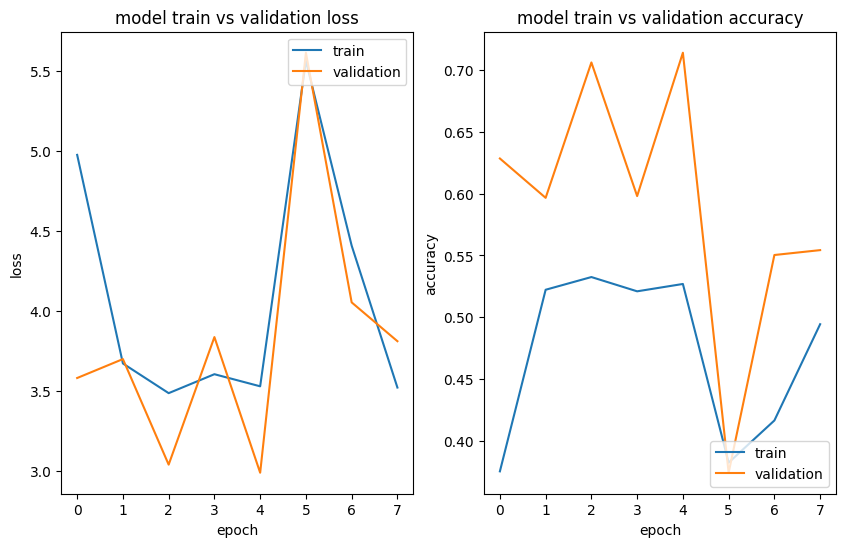

In [20]:
# plot the loss
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
plt.plot(history50.history['loss'])
plt.plot(history50.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

# plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(history50.history['accuracy'])
plt.plot(history50.history['val_accuracy'])
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')

# show the plots
plt.savefig('results/accuracy_loss_50.jpg')
plt.show()

#### Precision_score, Recall_score, F1_score, Perpelexity_score

In [21]:
# predict on a random subset of the test set
sample_indices = np.random.choice(len(test_data), size=1000, replace=False)
y_pred = model.predict(test_data[sample_indices])
y_pred = np.argmax(y_pred, axis=1)

# extract the corresponding labels
y_true = test_labels[sample_indices]

# calculate precision, recall, and F1-score for each class separately
precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
f1 = f1_score(y_true, y_pred, average='micro')

print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)

precision50 = precision
recall50 = recall
f150 = f1

32/32 [==============================] - 1s 13ms/step
Precision: 0.76214120076149
Recall: 0.583883751651255
F1-score: 0.678


In [22]:
# calculate perplexity in batches
batch_size = 1000
losses = []
accuracies = []
for i in range(0, len(test_data), batch_size):
    batch_data = test_data[i:i+batch_size]
    batch_labels = test_labels[i:i+batch_size]
    loss, accuracy = model.evaluate(batch_data, batch_labels, verbose=0)
    losses.append(loss)
    accuracies.append(accuracy)

# calculate overall perplexity
mean_loss = np.mean(losses)
perplexity = np.exp(mean_loss)

print('Perplexity:', perplexity)
perplexity50 = perplexity

Perplexity: 33.384528875975455


### Model with 100 hiden layers and learning_rate = 0.01

In [23]:
model = Sequential()
model.add(Embedding(num_words, embedding_dim, weights=[embedding_matrix], trainable=False))
model.add(LSTM(100, activation='relu', dropout=0.5, recurrent_dropout=0.2))
model.add(Dense(num_words, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.01), 
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 50)          2723100   
                                                                 
 lstm_1 (LSTM)               (None, 100)               60400     
                                                                 
 dense_1 (Dense)             (None, 54462)             5500662   
                                                                 
Total params: 8,284,162
Trainable params: 5,561,062
Non-trainable params: 2,723,100
_________________________________________________________________


In [24]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history100 = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, batch_size=100, callbacks=[early_stopping])


Epoch 1/50
5887/5887 [==============================] - 1043s 177ms/step - loss: 3.7911 - accuracy: 0.5516 - val_loss: 1.9344 - val_accuracy: 0.7923
Epoch 2/50
5887/5887 [==============================] - 1005s 171ms/step - loss: 2.1702 - accuracy: 0.7189 - val_loss: 1.5821 - val_accuracy: 0.8512
Epoch 3/50
5887/5887 [==============================] - 1045s 177ms/step - loss: 1.7140 - accuracy: 0.7607 - val_loss: 1.3599 - val_accuracy: 0.8787
Epoch 4/50
5887/5887 [==============================] - 1058s 180ms/step - loss: 1.4751 - accuracy: 0.7825 - val_loss: 1.2281 - val_accuracy: 0.8943
Epoch 5/50
5887/5887 [==============================] - 1087s 185ms/step - loss: 1.3266 - accuracy: 0.7974 - val_loss: 1.2276 - val_accuracy: 0.9002
Epoch 6/50
5887/5887 [==============================] - 1107s 188ms/step - loss: 1.2000 - accuracy: 0.8108 - val_loss: 1.2231 - val_accuracy: 0.9126
Epoch 7/50
5887/5887 [==============================] - 1127s 191ms/step - loss: 1.1435 - accuracy: 0.8169

#### Evaluate the model, accuracy and loss on test

In [25]:
# Evaluate the model
loss, accuracy = model.evaluate(test_data, test_labels, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)
loss100 = loss
accuracy100 = accuracy

Test loss: 1.5431106090545654
Test accuracy: 0.9079428911209106


#### Save the results 

In [26]:
# create the results directory if it doesn't exist
if not os.path.exists('results'):
    os.makedirs('results')

# save the history object as a file in the results directory
with open('results/history100.pkl', 'wb') as f:
    pickle.dump(history100.history, f)

In [28]:
with open('results/history100.pkl', 'rb') as f:
    history100 = pickle.load(f)

#### Load the history dictionary from the original model results

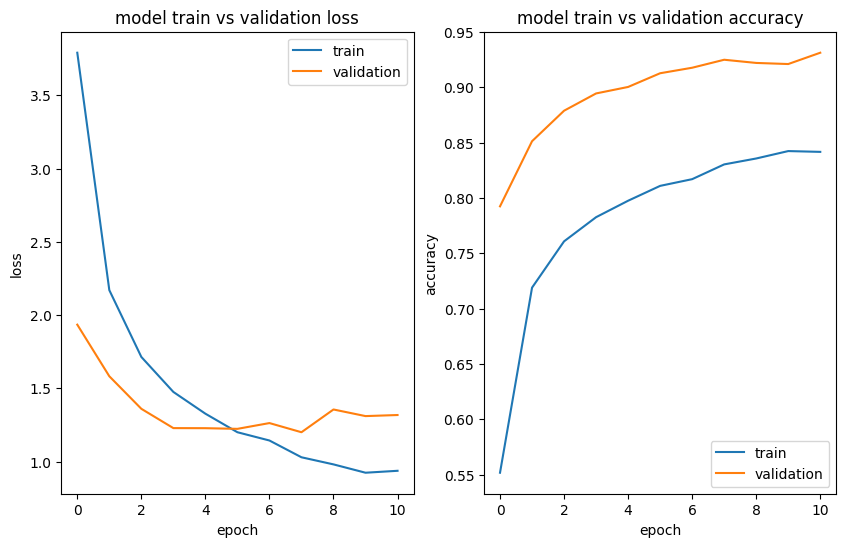

In [27]:
# plot the loss
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
plt.plot(history100.history['loss'])
plt.plot(history100.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

# plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(history100.history['accuracy'])
plt.plot(history100.history['val_accuracy'])
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')

# show the plots
plt.savefig('results/accuracy_loss_100.jpg')
plt.show()

#### Precision_score, Recall_score, F1_score, Perpelexity_score

In [28]:
# predict on a random subset of the test set
sample_indices = np.random.choice(len(test_data), size=1000, replace=False)
y_pred = model.predict(test_data[sample_indices])
y_pred = np.argmax(y_pred, axis=1)

# extract the corresponding labels
y_true = test_labels[sample_indices]

# calculate precision, recall, and F1-score for each class separately
precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
f1 = f1_score(y_true, y_pred, average='micro')

print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)

precision100 = precision
recall100 = recall
f1100 = f1

32/32 [==============================] - 1s 18ms/step
Precision: 0.8864468864468864
Recall: 0.8759811616954474
F1-score: 0.918


In [29]:
# calculate perplexity in batches
batch_size = 1000
losses = []
accuracies = []
for i in range(0, len(test_data), batch_size):
    batch_data = test_data[i:i+batch_size]
    batch_labels = test_labels[i:i+batch_size]
    loss, accuracy = model.evaluate(batch_data, batch_labels, verbose=0)
    losses.append(loss)
    accuracies.append(accuracy)

# calculate overall perplexity
mean_loss = np.mean(losses)
perplexity = np.exp(mean_loss)

print('Perplexity:', perplexity)
perplexity100 = perplexity

Perplexity: 4.681383837668897


### Model with 150 hiden layers and learning_rate = 0.1

In [30]:
model = Sequential()
model.add(Embedding(num_words, embedding_dim, weights=[embedding_matrix], trainable=False))
model.add(LSTM(150, activation='relu', dropout=0.5, recurrent_dropout=0.2))
model.add(Dense(num_words, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.1), 
              metrics=['accuracy']) 
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 50)          2723100   
                                                                 
 lstm_2 (LSTM)               (None, 150)               120600    
                                                                 
 dense_2 (Dense)             (None, 54462)             8223762   
                                                                 
Total params: 11,067,462
Trainable params: 8,344,362
Non-trainable params: 2,723,100
_________________________________________________________________


In [31]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history150 = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, batch_size=100, callbacks=[early_stopping])


Epoch 1/50
5887/5887 [==============================] - 1553s 263ms/step - loss: 59.2600 - accuracy: 0.0457 - val_loss: 32.4829 - val_accuracy: 0.0566
Epoch 2/50
5887/5887 [==============================] - 1668s 283ms/step - loss: 67.7939 - accuracy: 0.0469 - val_loss: 37.3097 - val_accuracy: 0.0429
Epoch 3/50
5887/5887 [==============================] - 1327s 225ms/step - loss: 57.2227 - accuracy: 0.0505 - val_loss: 22.2881 - val_accuracy: 0.0614
Epoch 4/50
5887/5887 [==============================] - 1377s 234ms/step - loss: 28.4253 - accuracy: 0.0633 - val_loss: 15.3902 - val_accuracy: 0.0730
Epoch 5/50
5887/5887 [==============================] - 1725s 293ms/step - loss: 14.0776 - accuracy: 0.0711 - val_loss: 9.0733 - val_accuracy: 0.0768
Epoch 6/50
5887/5887 [==============================] - 1340s 228ms/step - loss: 8.8232 - accuracy: 0.0775 - val_loss: 7.8783 - val_accuracy: 0.0782
Epoch 7/50
5887/5887 [==============================] - 1351s 230ms/step - loss: 7.7142 - accurac

#### Evaluate the model, accuracy and loss on test

In [32]:
# Evaluate the model
loss, accuracy = model.evaluate(test_data, test_labels, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

loss150 = loss
accuracy150 = accuracy

Test loss: 8.166196823120117
Test accuracy: 0.08054332435131073


#### Save the results 

In [33]:
# create the results directory if it doesn't exist
if not os.path.exists('results'):
    os.makedirs('results')

# save the history object as a file in the results directory
with open('results/history150.pkl', 'wb') as f:
    pickle.dump(history150.history, f)

In [32]:
with open('results/history150.pkl', 'rb') as f:
    history150 = pickle.load(f)

#### Load the history dictionary from the original model results

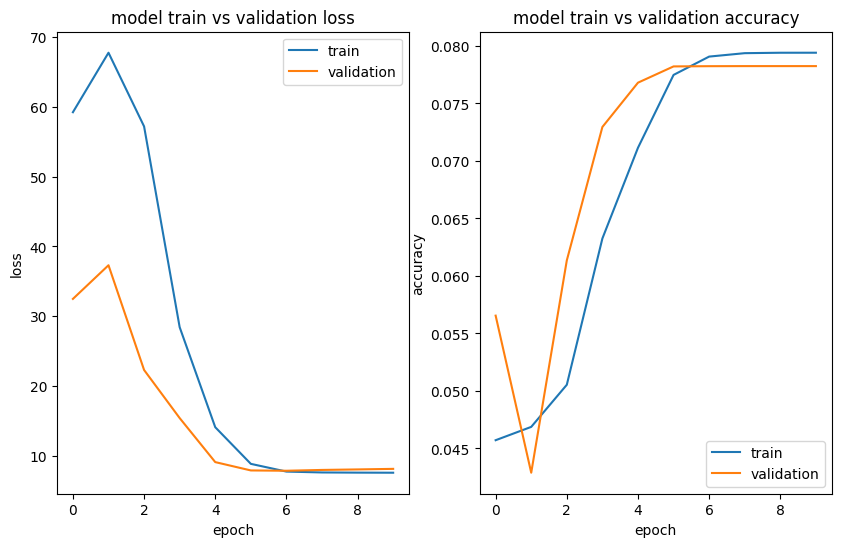

In [34]:
# plot the loss
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
plt.plot(history150.history['loss'])
plt.plot(history150.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

# plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(history150.history['accuracy'])
plt.plot(history150.history['val_accuracy'])
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')

# show the plots
plt.savefig('results/accuracy_loss_150.jpg')
plt.show()

#### Precision_score, Recall_score, F1_score, Perpelexity_score

In [35]:
# predict on a random subset of the test set
sample_indices = np.random.choice(len(test_data), size=1000, replace=False)
y_pred = model.predict(test_data[sample_indices])
y_pred = np.argmax(y_pred, axis=1)

# extract the corresponding labels
y_true = test_labels[sample_indices]

# calculate precision, recall, and F1-score for each class separately
precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
f1 = f1_score(y_true, y_pred, average='micro')

print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)

precision150 = precision
recall150 = recall
f1150 = f1

32/32 [==============================] - 1s 24ms/step
Precision: 0.9984203389830508
Recall: 0.001694915254237288
F1-score: 0.068


In [36]:
# calculate perplexity in batches
batch_size = 1000
losses = []
accuracies = []
for i in range(0, len(test_data), batch_size):
    batch_data = test_data[i:i+batch_size]
    batch_labels = test_labels[i:i+batch_size]
    loss, accuracy = model.evaluate(batch_data, batch_labels, verbose=0)
    losses.append(loss)
    accuracies.append(accuracy)

# calculate overall perplexity
mean_loss = np.mean(losses)
perplexity = np.exp(mean_loss)

print('Perplexity:', perplexity)
perplexity150 = perplexity

Perplexity: 3520.889273727999


## Compare results

In [37]:
loss_comp = {}
accuracy_comp = {}
precision_comp = {}
recall_comp = {}
f1_score_comp = {}
perplexity_comp = {}

loss_comp = {'loss50':loss50, 'loss100':loss100, 'loss150':loss150}
accuracy_comp = {'accuracy50':accuracy50, 'accuracy100':accuracy100, 'accuracy150':accuracy150}
precision_comp = {'precision50':precision50, 'precision100':precision100, 'precision150':precision150}
recall_comp = {'recall50':recall50, 'recall100':recall100, 'recall150':recall150}
f1_score_comp = {'f150':f150, 'f1100':f1100, 'f1150':f1150}
perplexity_comp = {'perplexity50':perplexity50, 'perplexity100':perplexity100, 'perplexity150':perplexity150}

In [38]:
loss_comp 

{'loss50': 3.507746934890747,
 'loss100': 1.5431106090545654,
 'loss150': 8.166196823120117}

In [39]:
accuracy_comp

{'accuracy50': 0.6845651865005493,
 'accuracy100': 0.9079428911209106,
 'accuracy150': 0.08054332435131073}

In [40]:
precision_comp 

{'precision50': 0.76214120076149,
 'precision100': 0.8864468864468864,
 'precision150': 0.9984203389830508}

In [41]:
recall_comp 

{'recall50': 0.583883751651255,
 'recall100': 0.8759811616954474,
 'recall150': 0.001694915254237288}

In [42]:
f1_score_comp

{'f150': 0.678, 'f1100': 0.918, 'f1150': 0.068}

In [43]:
perplexity_comp

{'perplexity50': 33.384528875975455,
 'perplexity100': 4.681383837668897,
 'perplexity150': 3520.889273727999}

In [47]:
import csv

# Writing data to CSV
with open('results\results_compare.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['loss', 'accuracy', 'precision', 'recall', 'f1_score', 'perplexity'])
    for key in loss_comp.keys():
        if key in accuracy_comp and key in precision_comp and key in recall_comp and key in f1_score_comp and key in perplexity_comp:
            writer.writerow([loss_comp[key], accuracy_comp[key], precision_comp[key], recall_comp[key], f1_score_comp[key], perplexity_comp[key]])

# Reading data from CSV
with open('results\results_compare.csv') as file:
    reader = csv.reader(file)
    for row in reader:
        print(row)


['loss', 'accuracy', 'precision', 'recall', 'f1_score', 'perplexity']


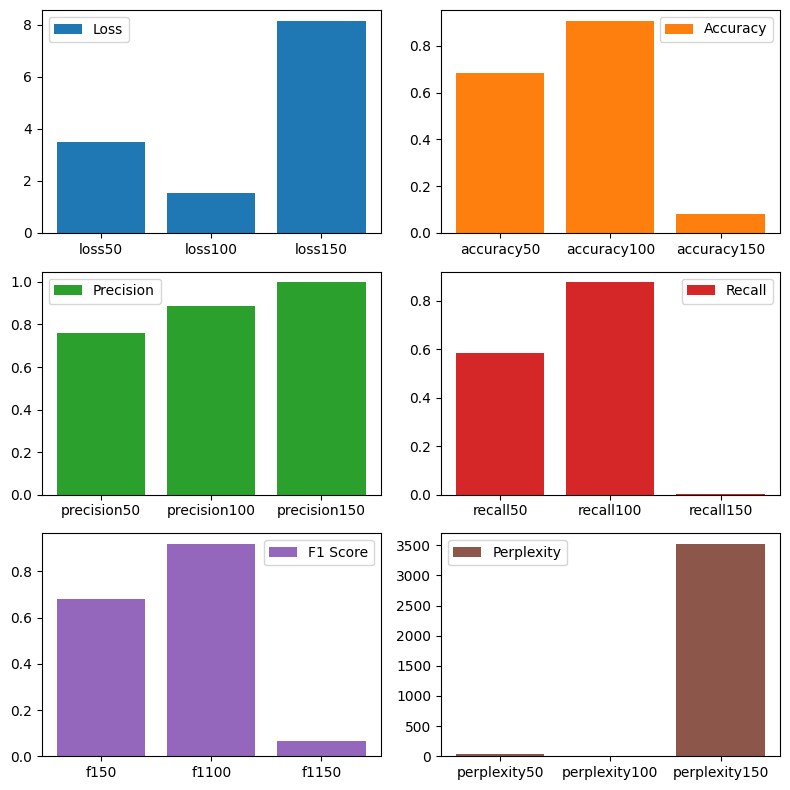

In [46]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(8, 8))

# Set the colors for each bar
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# Plot each chart as a bar chart with different colors and labels
axs[0, 0].bar(loss_comp.keys(), loss_comp.values(), color=colors[0], label='Loss')
axs[0, 0].legend()
axs[0, 1].bar(accuracy_comp.keys(), accuracy_comp.values(), color=colors[1], label='Accuracy')
axs[0, 1].legend()
axs[1, 0].bar(precision_comp.keys(), precision_comp.values(), color=colors[2], label='Precision')
axs[1, 0].legend()
axs[1, 1].bar(recall_comp.keys(), recall_comp.values(), color=colors[3], label='Recall')
axs[1, 1].legend()
axs[2, 0].bar(f1_score_comp.keys(), f1_score_comp.values(), color=colors[4], label='F1 Score')
axs[2, 0].legend()
axs[2, 1].bar(perplexity_comp.keys(), perplexity_comp.values(), color=colors[5], label='Perplexity')
axs[2, 1].legend()

plt.tight_layout()
plt.savefig('results/Bar_chart_compare.jpg')
plt.show()


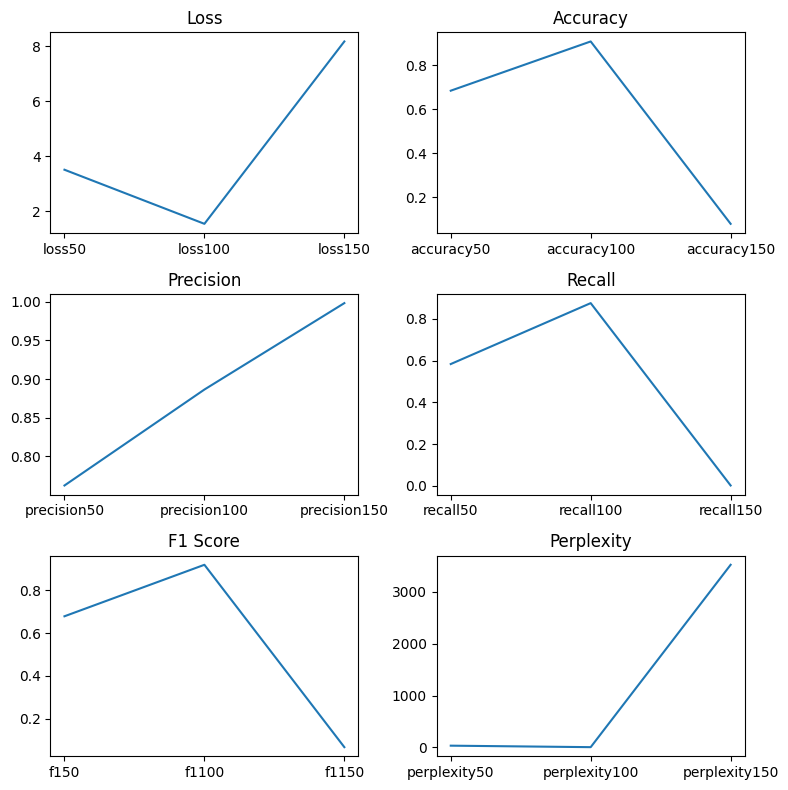

In [47]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(8, 8))
axs[0, 0].plot(loss_comp.keys(), loss_comp.values())
axs[0, 0].set_title('Loss')
axs[0, 1].plot(accuracy_comp.keys(), accuracy_comp.values())
axs[0, 1].set_title('Accuracy')
axs[1, 0].plot(precision_comp.keys(), precision_comp.values())
axs[1, 0].set_title('Precision')
axs[1, 1].plot(recall_comp.keys(), recall_comp.values())
axs[1, 1].set_title('Recall')
axs[2, 0].plot(f1_score_comp.keys(), f1_score_comp.values())
axs[2, 0].set_title('F1 Score')
axs[2, 1].plot(perplexity_comp.keys(), perplexity_comp.values())
axs[2, 1].set_title('Perplexity')

plt.tight_layout()
plt.savefig('results/Chart_compare.jpg')
plt.show()


# Reading the Results

In [48]:
def generate_text(model, seed_text, next_words, temperature):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=length-1, padding='pre')
        predicted_probs = model.predict(token_list)[0]
        predicted_probs = np.log(predicted_probs + 1e-20) / temperature  # add small value to prevent divide-by-zero errors
        predicted_probs = np.exp(predicted_probs) / np.sum(np.exp(predicted_probs))
        predicted = np.random.choice(len(predicted_probs), p=predicted_probs)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text


In [49]:
# generate text with temperature parameter of 0.5
seed_text = 'Natural language'
generated_text = generate_text(model, seed_text, next_words=100, temperature=0.5)
print(generated_text)


1/1 [==============================] - 0s 35ms/step
Natural language and the the to of the the the the the the of are the of and the and the the to to to the the and the the the the the the of of of the the for is to in to the the the the the of a the the the the the in had the to of the the the of and the is the the of the the the of a and the the and the that the the and of a and in the the to i the of the of the and to of they


# Second Part

### Read the contents of the file (Attention: we have to reduct the data set, because if we do not do that, it's not executable in computer and memory is crashed.

In [3]:
# read the contents of the file
with open('dataset/train1.txt', 'r') as f:
    train = f.read()
    
with open('dataset/test1.txt', 'r') as f:
    test = f.read()

In [4]:
def clean_txt(corpus):
    tokens = corpus.split()
    tokens = [t for t in tokens if t not in string.punctuation]
    tokens = [t for t in tokens if t.isalpha()]
    tokens = [t.lower() for t in tokens]
    return tokens

In [6]:
corpus = []
corpus1 = []
art = clean_txt(train)
for word in art:
    corpus.append(word)
art1 = clean_txt(test)
for word in art1:
    corpus1.append(word)
print('Total Tokens of train: ',len(corpus)) 
print('Total uniq Tokens of train: ',len(set(corpus))) 
print('Total Tokens of test: ',len(corpus1)) 
print('Total uniq Tokens of test: ',len(set(corpus1))) 

Total Tokens of train:  4526
Total uniq Tokens of train:  1277
Total Tokens of test:  2465
Total uniq Tokens of test:  1059


## Convert all words to lowercase & Get a set of unique words

In [7]:
# Convert all words to lowercase
corpus_art = [word.lower() for word in art+art1]

# Get a set of unique words
vocab_words = set(corpus_art)

# Convert the set back to a list
vocab_words = list(vocab_words)

In [8]:
length = 4 + 1
seq = []
seq1 = []
for i in range(length,len(corpus)):
    sequence = corpus[i-length:i]
    lines = ' '.join(sequence)
    seq.append(lines)
print('Total Sequence of train: ',len(seq)) 

for i in range(length,len(corpus1)):
    sequence = corpus1[i-length:i]
    lines = ' '.join(sequence)
    seq1.append(lines)
print('Total Sequence of test: ',len(seq1))

Total Sequence of train:  4521
Total Sequence of test:  2460


## Tokenize the dataset and convert into the Sequences

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(seq + seq1) 

train_sequences = tokenizer.texts_to_sequences(seq)
test_sequences = tokenizer.texts_to_sequences(seq1)

In [10]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

2073


In [11]:
max_length = 4
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')

## Take contex and center vector

In [12]:
train_data = []
train_labels = []
for seq in train_sequences:
    for i in range(2, len(seq) - 2):
        train_data.append(seq[:4])
        train_labels.append(seq[4:5])
train_data = np.array(train_data)
train_labels = np.array(train_labels)

test_data = []
test_labels = []
for seq in test_sequences:
    for i in range(2, len(seq) - 2):
        test_data.append(seq[:4])
        test_labels.append(seq[4:5])
test_data = np.array(test_data)
test_labels = np.array(test_labels)

## Pad documents to a max length of 4 words

In [13]:
# pad documents to a max length of 4 words
max_length = 4
padded_docs = pad_sequences(train_sequences, maxlen=max_length, padding='post')
padded_docs_test = pad_sequences(test_sequences, maxlen=max_length, padding='post')

In [14]:
X_tr, X_v, y_tr, y_v = train_test_split(padded_docs, train_labels, test_size=0.2)


## One-hot encodding

In [15]:
embedding_dim = 50
X_train = to_categorical(X_tr,num_classes=vocab_size)
X_val = to_categorical(X_v,num_classes=vocab_size)
y_train = to_categorical(y_tr,num_classes=vocab_size)
y_val = to_categorical(y_v,num_classes=vocab_size)

X_test = to_categorical(padded_docs_test,num_classes=vocab_size)
y_test = to_categorical(test_labels,num_classes=vocab_size)

## Reshape input data to be three-dimensional

In [16]:
# reshape input data to be three-dimensional
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], -1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], -1))

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], -1))

In [17]:
#from keras.regularizers import l2
#from keras.layers import Dropout

model = Sequential()
model.add(LSTM(units=50, activation='sigmoid', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, kernel_regularizer=l2(1.0e-7), dropout=0.2, recurrent_dropout=0.2, trainable=True))
#model.add(Dropout(0.2))
model.add(LSTM(units=200, activation='relu', dropout=0.5, recurrent_dropout=0.5, return_sequences=True, kernel_regularizer=l2(1.0e-7)))
model.add(Dropout(0.2))
model.add(LSTM(units=100, activation='relu', dropout=0.5, recurrent_dropout=0.5, kernel_regularizer=l2(1.0e-7)))
#model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=vocab_size, activation='softmax', kernel_regularizer=l2(1.0e-7)))
model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# print model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 50)             424800    
                                                                 
 lstm_1 (LSTM)               (None, 4, 200)            200800    
                                                                 
 dropout (Dropout)           (None, 4, 200)            0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               120400    
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 2073)              209373    
                                                                 
Total params: 955,373
Trainable params: 955,373
Non-trai

In [18]:
# fit the model
early_stopping = EarlyStopping(monitor='val_loss', patience=60, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=150, batch_size=50, callbacks=[early_stopping])


Epoch 1/150
73/73 [==============================] - 14s 86ms/step - loss: 6.6154 - accuracy: 0.0384 - val_loss: 6.3109 - val_accuracy: 0.0785
Epoch 2/150
73/73 [==============================] - 5s 74ms/step - loss: 5.8764 - accuracy: 0.0664 - val_loss: 6.3848 - val_accuracy: 0.0785
Epoch 3/150
73/73 [==============================] - 5s 75ms/step - loss: 5.8164 - accuracy: 0.0669 - val_loss: 6.4832 - val_accuracy: 0.0785
Epoch 4/150
73/73 [==============================] - 5s 75ms/step - loss: 5.8046 - accuracy: 0.0669 - val_loss: 6.5497 - val_accuracy: 0.0785
Epoch 5/150
73/73 [==============================] - 5s 75ms/step - loss: 5.7908 - accuracy: 0.0669 - val_loss: 6.5855 - val_accuracy: 0.0785
Epoch 6/150
73/73 [==============================] - 6s 75ms/step - loss: 5.7679 - accuracy: 0.0669 - val_loss: 6.5445 - val_accuracy: 0.0785
Epoch 7/150
73/73 [==============================] - 6s 75ms/step - loss: 5.5364 - accuracy: 0.0661 - val_loss: 5.9795 - val_accuracy: 0.0785
Epoch

73/73 [==============================] - 5s 73ms/step - loss: 2.5299 - accuracy: 0.4425 - val_loss: 5.4499 - val_accuracy: 0.5116
Epoch 59/150
73/73 [==============================] - 5s 73ms/step - loss: 2.5600 - accuracy: 0.4256 - val_loss: 5.6487 - val_accuracy: 0.5039
Epoch 60/150
73/73 [==============================] - 5s 74ms/step - loss: 2.5012 - accuracy: 0.4309 - val_loss: 5.6565 - val_accuracy: 0.5238
Epoch 61/150
73/73 [==============================] - 5s 73ms/step - loss: 2.5298 - accuracy: 0.4331 - val_loss: 5.4443 - val_accuracy: 0.5138
Epoch 62/150
73/73 [==============================] - 5s 74ms/step - loss: 2.4592 - accuracy: 0.4441 - val_loss: 5.5472 - val_accuracy: 0.5083
Epoch 63/150
73/73 [==============================] - 5s 73ms/step - loss: 2.4077 - accuracy: 0.4571 - val_loss: 5.5448 - val_accuracy: 0.5227
Epoch 64/150
73/73 [==============================] - 5s 74ms/step - loss: 2.4241 - accuracy: 0.4563 - val_loss: 5.5231 - val_accuracy: 0.5138
Epoch 65/150

73/73 [==============================] - 5s 73ms/step - loss: 1.4520 - accuracy: 0.6510 - val_loss: 5.4034 - val_accuracy: 0.5890
Epoch 116/150
73/73 [==============================] - 5s 74ms/step - loss: 1.4317 - accuracy: 0.6618 - val_loss: 5.4914 - val_accuracy: 0.5768
Epoch 117/150
73/73 [==============================] - 5s 73ms/step - loss: 1.4771 - accuracy: 0.6574 - val_loss: 5.3988 - val_accuracy: 0.5746
Epoch 118/150
73/73 [==============================] - 5s 73ms/step - loss: 1.4052 - accuracy: 0.6762 - val_loss: 5.4269 - val_accuracy: 0.5823
Epoch 119/150
73/73 [==============================] - 5s 74ms/step - loss: 1.4820 - accuracy: 0.6527 - val_loss: 5.4080 - val_accuracy: 0.5779
Epoch 120/150
73/73 [==============================] - 5s 74ms/step - loss: 1.4135 - accuracy: 0.6726 - val_loss: 5.3573 - val_accuracy: 0.5834
Epoch 121/150
73/73 [==============================] - 5s 74ms/step - loss: 1.4237 - accuracy: 0.6654 - val_loss: 5.3943 - val_accuracy: 0.5746
Epoch 

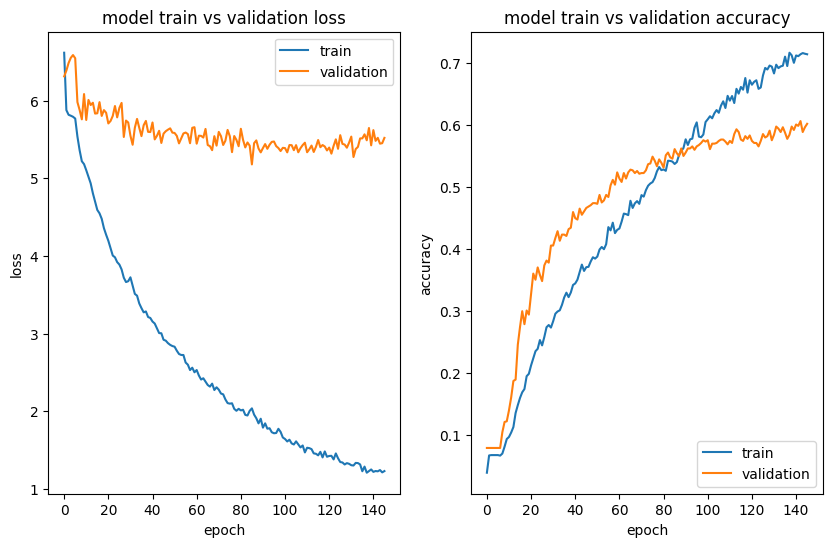

In [20]:
# plot the loss
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

# plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')

# show the plots
plt.savefig('results/accuracy_loss_one-hot.jpg')
plt.show()

In [22]:
#from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Evaluate model on test data
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

# Make predictions on test data
y_pred_prob = model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred_prob, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Calculate precision, recall, and F1-score with zero division set to 1
precision = precision_score(y_true_labels, y_pred_labels, average='macro', zero_division=1)
recall = recall_score(y_true_labels, y_pred_labels, average='macro', zero_division=1)
f1 = f1_score(y_true_labels, y_pred_labels, average='micro', zero_division=1)

# Calculate classification report
#report = classification_report(y_true_labels, y_pred_labels)

# Calculate perplexity
perplexity = np.exp(loss)

print('Test loss:', loss)
print('Test accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)
print('Perplexity:', perplexity)


77/77 [==============================] - 1s 13ms/step
Test loss: 5.945165157318115
Test accuracy: 0.4719512164592743
Precision: 0.8032265280339612
Recall: 0.19934547770603184
F1-score: 0.4719512195121951
Perplexity: 381.902430070521
